In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import my_function
import time_dependent_tree
import random
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL

In [2]:
np.random.seed(314) # 乱数シードを314に設定
# 合成波の作成
syn_t = my_function.make_wave(0.5, 1.0, 3.0, 100)[0]
syn_y = my_function.make_wave(0.5, 1.0, 3.0, 100)[1] + my_function.make_wave(0.75, 1.7, 3.0, 100)[1] + 0.05 * np.random.randn(len(syn_t))

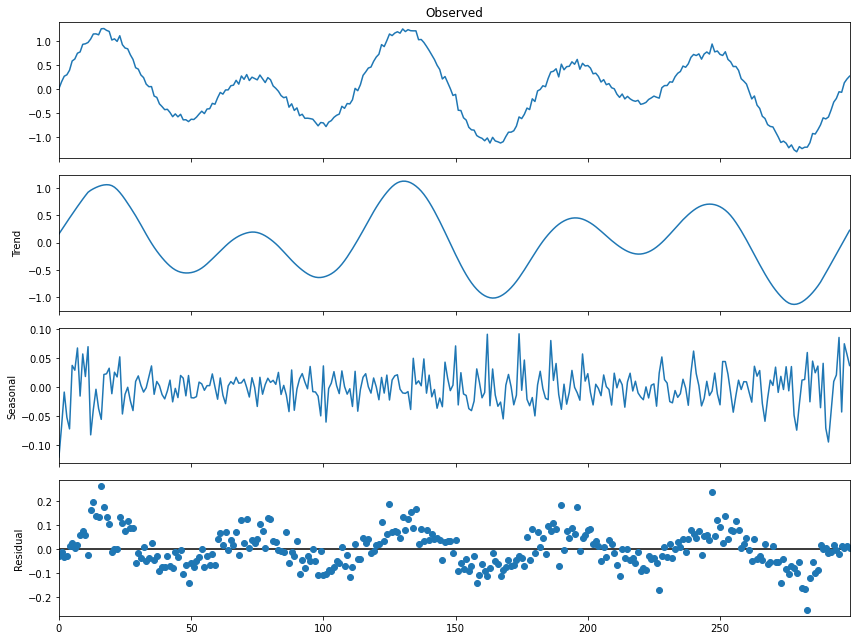

In [3]:
# STL分解
stl=STL(syn_y, period=12, robust=True)
stl_series = stl.fit()
# STL分解結果のグラフ化
plt.rcParams['figure.figsize'] = [12, 9]
stl_series.plot()
plt.show()

In [4]:
# データの整形
trend_x, trend_y = my_function.sliding_window(stl_series.trend)
seasonal_x, seasonal_y = my_function.sliding_window(stl_series.seasonal)
resid_x, resid_y = my_function.sliding_window(stl_series.resid)

# データの分割
trend_x_train, trend_x_test, trend_y_train, trend_y_test = train_test_split(trend_x, trend_y, test_size=0.1, shuffle=False)
seasonal_x_train, seasonal_x_test, seasonal_y_train, seasonal_y_test = train_test_split(seasonal_x, seasonal_y, test_size=0.1, shuffle=False)
resid_x_train, resid_x_test, resid_y_train, resid_y_test = train_test_split(resid_x, resid_y, test_size=0.1, shuffle=False)

In [5]:
trend_tdtree = time_dependent_tree.TimeDependentTree(trend_x_train, trend_y_train, trend_x_test, trend_y_test, 5, 5)
seasonal_tdtree = time_dependent_tree.TimeDependentTree(seasonal_x_train, seasonal_y_train, seasonal_x_test, seasonal_y_test, 5, 5)
resid_tdtree = time_dependent_tree.TimeDependentTree(resid_x_train, resid_y_train, resid_x_test, resid_y_test, 5, 5)

In [6]:
trend_tdtree.train()
seasonal_tdtree.train()
resid_tdtree.train()

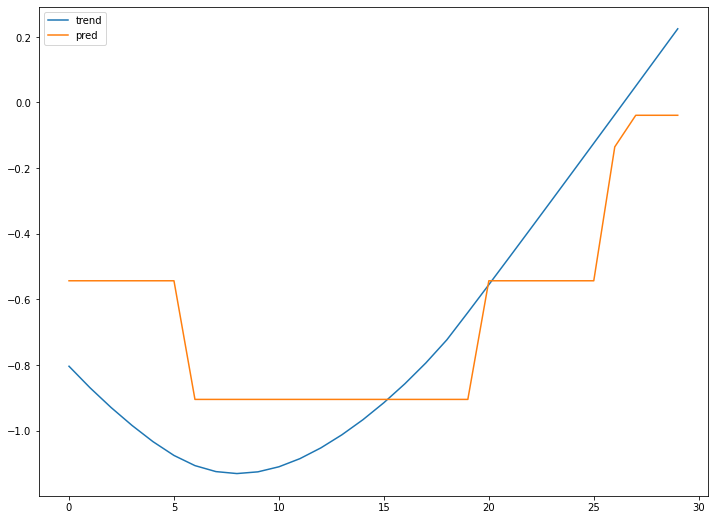

In [10]:
plt.plot(trend_y_test, label='trend')
plt.plot(trend_tdtree.predict(), label='pred')
plt.legend()
plt.show()

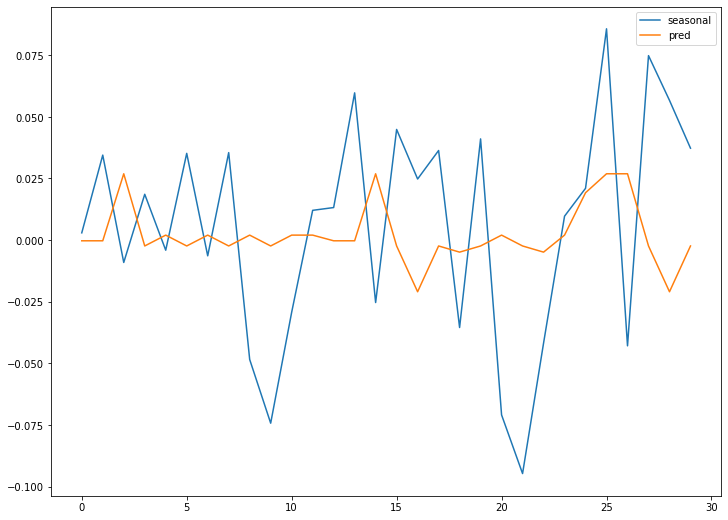

In [11]:
plt.plot(seasonal_y_test, label='seasonal')
plt.plot(seasonal_tdtree.predict(), label='pred')
plt.legend()
plt.show()

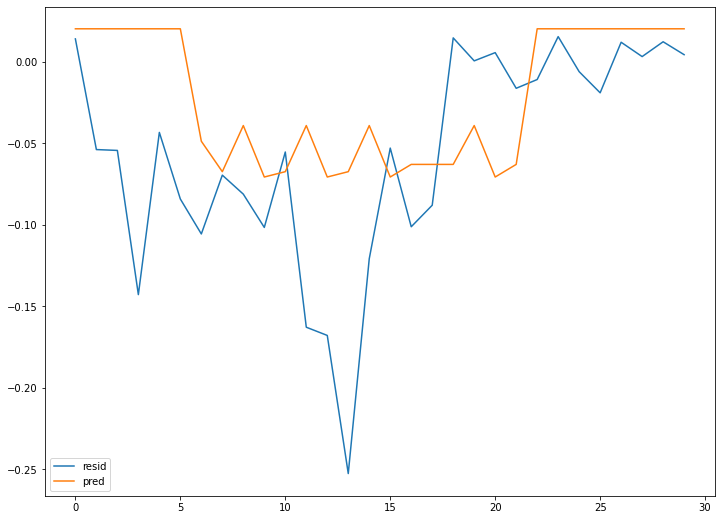

In [12]:
plt.plot(resid_y_test, label='resid')
plt.plot(resid_tdtree.predict(), label='pred')
plt.legend()
plt.show()